# TODO:

[ ] ilk 15 nükleotidi find_matches'ta atlamak gerek

[ ] print_results'ta index kaynaklı ilk 24 nükleotitteki sonuçlarda sorun var

[ ] print_results bazen düzgün printlemiyor



In [1]:
# parameters for TP53

seq_file = "../sequences/tp53/Homo_sapiens_ENST00000420246_2_sequence.fa"
canonical_result_file = (
    "../sequences/tp53/TargetScan_8.0_ENST00000420246.2_predicted_targeting_details.txt"
)

# required functions

In [2]:
# importing dependencies
from Bio import SeqIO
import pandas as pd
from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib_venn as venn

import itertools
import numpy as np

# debug
from icecream import ic

In [3]:
def import_fasta(fasta):

    with open(fasta) as f:
        records = SeqIO.parse(f, "fasta")
        transcripts = [dna_to_mrna(str(rec.seq)) for rec in records]
        return "".join(transcripts)


def complement(string):

    result = ""
    for nuc in string:
        if nuc == "A":
            result += "U"
        elif nuc == "C":
            result += "G"
        elif nuc == "G":
            result += "C"
        elif nuc in ["U", "T"]:
            result += "A"
    return result


def uracil_to_thymine(string):
    return "".join("T" if nuc == "U" else nuc for nuc in string)


def mirna_to_mrna(string):
    return complement(string[::-1])


def dna_to_mrna(string):
    return "".join("U" if nuc == "T" else nuc for nuc in string)


def sliding_window(sequence, win_size):
    for i in range(len(sequence) - win_size + 1):
        yield sequence[i: i + win_size]


def create_targetscan_db():

    df = pd.read_csv(
        "../sequences/mirna/targetscan_mirnas.txt", sep="\t", header=0)

    # dropping non-human miRNAs
    df = df[df["Species ID"] == 9606]
    # dropping unnecessary columns
    df = df.drop(["miR family", "Species ID", "MiRBase Accession"], axis=1)

    # reordering columns
    df = df.iloc[:, [1, 2, 0, 3]]

    # renaming columns
    renaming_dict = {
        "Seed+m8": "seed",
        "MiRBase ID": "name",
        "Mature sequence": "sequence",
        "Family Conservation?": "conservation",
    }

    df.rename(columns=renaming_dict, inplace=True)

    df["sequence"] = df["sequence"].apply(mirna_to_mrna)
    df["seed"] = df["seed"].apply(mirna_to_mrna)

    # trimming 7mer seed into 6mer
    df["seed"] = df["seed"].str[1:]

    return df


def create_mirbase_db():
    with open("../sequences/mirna/mature_mirnas.fa") as f:

        # initializing lists to zip into a df
        names = []
        sequences = []

        for record in SeqIO.parse(f, "fasta"):

            name = str(record.id)
            if name.startswith("hsa"):  # drops all non-human entries
                sequence = str(record.seq)

                # adding name
                names.append(name)

                # adding mRNA sequence
                sequences.append(mirna_to_mrna(sequence))

    return pd.DataFrame(list(zip(names, sequences)), columns=["name", "sequence"])


def find_matches(sequence, mirna_df):

    # pythonic
    mirna_names = mirna_df["name"].values.tolist()
    mirna_sequences = mirna_df["sequence"].values.tolist()
    mirna_seeds = [seq[-7:-1] for seq in mirna_sequences]
    generator = sliding_window(dna_to_mrna(sequence), 10)

    # creating seed dict
    seed_dict = defaultdict(list)
    for i in range(len(mirna_names)):
        seed_dict[mirna_seeds[i]].append((mirna_names[i], mirna_sequences[i]))

    # initializing lists
    names = []
    coordinates = []
    start_coords = []
    end_coords = []
    seed_matches = []
    match_types = []
    mirna_sequences = []

    # for loop
    for c, chunk in enumerate(generator, start=1):

        seed = chunk[2:8]

        if seed in seed_dict:
            m8 = chunk[1]

            anchor_a = chunk[8] == "A"

            # this count is named as c2 to discriminate between 2 counts
            c2 = 0
            for record in seed_dict[seed]:
                mirna_sequence = seed_dict[seed][c2][1]
                m8_match = m8 == mirna_sequence[-8]
                c2 += 1
                if anchor_a and m8_match:
                    match_types.append("8mer")
                    start_coords.append(c + 1)
                    end_coords.append(c + 8)
                    coordinates.append(f"{str(c + 1)}-{str(c + 8)}")
                    seed_matches.append(chunk[1:9])

                elif anchor_a:
                    match_types.append("7mer-A1")
                    start_coords.append(c + 2)
                    end_coords.append(c + 8)
                    coordinates.append(f"{str(c + 2)}-{str(c + 8)}")
                    seed_matches.append(chunk[2:9])

                elif m8_match:
                    match_types.append("7mer-m8")
                    start_coords.append(c + 1)
                    end_coords.append(c + 7)
                    coordinates.append(f"{str(c + 1)}-{str(c + 7)}")
                    seed_matches.append(chunk[1:8])

                else:
                    continue

                names.append(record[0])
                mirna_sequences.append(mirna_sequence)

    df = pd.DataFrame(
        list(
            zip(
                names,
                coordinates,
                start_coords,
                end_coords,
                seed_matches,
                match_types,
                mirna_sequences
            )
        ),
        columns=[
            "name",
            "coordinates",
            "start",
            "end",
            "seed match",
            "match_type",
            "mirna_sequence"
        ],
    )

    df["comparison"] = [f"{a}_{b}_{c}" for a,
                        b, c in zip(df.name, df.start, df.end)]
    return df


def compare_mirna_dataframes(mirbase, targetscan):

    mirbase_copy = mirbase.copy()
    targetscan_copy = targetscan.copy()

    # generating comparison columns
    mirbase_copy["comparison"] = [
        f"{a}_{b}" for a, b in zip(mirbase_copy.name, mirbase_copy.sequence)
    ]
    targetscan_copy["comparison"] = [
        f"{a}_{b}" for a, b in zip(targetscan_copy.name, targetscan_copy.sequence)
    ]

    mirbase_set = set(mirbase_copy["comparison"].values.tolist())
    targetscan_set = set(targetscan_copy["comparison"].values.tolist())

    total0 = len(mirbase_set.union(targetscan_set))
    venn.venn2(
        [mirbase_set, targetscan_set],
        set_labels=("miRBase", "TargetScan"),
        subset_label_formatter=lambda x: str(
            x) + "\n(" + f"{(x/total0):1.0%}" + ")",
    )
    plt.title("Fig 0: Differences between miRNA databases")
    plt.show()


def create_venn_diagrams(mirbase_set, targetscan_set, canonical_set):

    total1 = len(mirbase_set.union(targetscan_set))
    venn.venn2(
        [mirbase_set, targetscan_set],
        set_labels=("miRBase miRNAs", "TargetScan miRNAs"),
        subset_label_formatter=lambda x: str(
            x) + "\n(" + f"{(x/total1):1.0%}" + ")",
    )
    plt.title(
        "Fig 1: Results using miRBase miRNAs vs. Results using TargetScan miRNAs")
    plt.show()

    total2 = len(mirbase_set.union(canonical_set))
    venn.venn2(
        [mirbase_set, canonical_set],
        set_labels=("miRBase miRNAs", "TargetScan Canonical Results"),
        subset_label_formatter=lambda x: str(
            x) + "\n(" + f"{(x/total2):1.0%}" + ")",
    )
    plt.title("Fig 2: Results using miRBase miRNAs vs. TargetScan Canonical Results")
    plt.show()

    total3 = len(targetscan_set.union(canonical_set))
    venn.venn2(
        [targetscan_set, canonical_set],
        set_labels=("TargetScan miRNAs", "TargetScan Canonical Results"),
        subset_label_formatter=lambda x: str(
            x) + "\n(" + f"{(x/total3):1.0%}" + ")",
    )
    plt.title(
        "Fig 3: Results using TargetScan miRNAs vs. TargetScan Canonical Results")
    plt.show()

    triple = [mirbase_set, targetscan_set, canonical_set]
    venn.venn3(
        triple,
        set_labels=(
            "miRBase miRNAs",
            "TargetScan miRNAs",
            "TargetScan Canonical Results",
        ),
    )
    plt.title("Fig 4: Comparison of all results")
    plt.show()


def plot_venn_diagram(s1, s2, s1_name="set1", s2_name="set2"):

    total_number = len(s1.union(s2))
    venn.venn2(
        [s1, s2],
        set_labels=(s1_name, s2_name),
        subset_label_formatter=lambda x: str(x)
        + "\n("
        + f"{(x/total_number):1.0%}"
        + ")",
    )
    # plt.title("Fig 3: Results using TargetScan miRNAs vs. TargetScan Canonical Results")
    plt.show()


def parse_targetscan_result_file(f):
    df = pd.read_csv(f, sep="\t")
    # df = df.drop([df.index[0], df.index[1], df.index[2]])

    df.columns = [
        "name",
        "coordinates",
        "match_type",
        "c++_score",
        "c++_score_percentile",
        "weighted_c++_score",
        "conserved_branch_length",
        "pct",
        "relative_kd",
    ]

    df.drop(df.index[df["name"] == "Conserved sites"], inplace=True)
    df.drop(df.index[df["name"] == "Poorly conserved sites"], inplace=True)

    return df


def analyze_differences_between_sets(s1, s2):
    diff = s1.difference(s2)

    s1_names = []
    s1_start_coords = []
    s1_end_coords = []

    # unpacks previously concatenated mirna names and predicted positions
    for i in diff:
        temp = i.split("_")
        s1_names.append(temp[0])

        temp2 = temp[1].split("-")
        s1_start_coords.append(temp2[0])
        s1_end_coords.append(temp2[1])

    s2_start_coords = []
    s2_end_coords = []

    for s1_name in s1_names:

        # pythonic
        start = targetscan_results[targetscan_results["name"]
                                   == s1_name].start.values
        end = targetscan_results[targetscan_results["name"]
                                 == s1_name].end.values

        s2_start_coords.append(start)
        s2_end_coords.append(end)

    # result df
    column_names = ["name", "canonical_start",
                    "canonical_end", "our_start", "our_end"]
    df = pd.DataFrame(
        list(
            zip(
                s1_names, s1_start_coords, s1_end_coords, s2_start_coords, s2_end_coords
            )
        ),
        columns=column_names,
    )

    # exploding results
    df = df.explode("our_start")
    df = df.explode("our_end")

    # post explode
    df.fillna(0, inplace=True)

    # changing values into int
    df["canonical_start"] = df["canonical_start"].astype(int)
    df["canonical_end"] = df["canonical_end"].astype(int)
    df["our_start"] = df["our_start"].astype(int)
    df["our_end"] = df["our_end"].astype(int)

    # explode causes unwanted coordinate pairs, this part removes them
    # flags rows to be dropped with True
    df["flag"] = abs(df["our_end"] - df["our_start"]) > 10

    # drops True & flag column
    df = df[df["flag"] == False]
    df = df.drop("flag", axis=1)

    df["difference_between_starts"] = df["canonical_start"] - df["our_start"]
    df["difference_between_ends"] = df["canonical_end"] - df["our_end"]

    # additional flags
    df["missed"] = df["our_end"] == 0

    return df


def create_comparison_set(df):

    names = df["name"].values.tolist()
    coords = df["coordinates"].values.tolist()

    # zipping names and coordinates with underscore
    zipped_strings = [f"{m}_{n}" for m, n in zip(names, coords)]

    return set(zipped_strings)

# running the script and getting results

In [4]:
def find_matches(sequence, mirna_df):

    # pythonic
    mirna_names = mirna_df["name"].values.tolist()
    mirna_sequences = mirna_df["sequence"].values.tolist()
    mirna_seeds = [seq[-7:-1] for seq in mirna_sequences]
    generator = sliding_window(dna_to_mrna(sequence), 10)

    # creating seed dict
    seed_dict = defaultdict(list)
    for i in range(len(mirna_names)):
        seed_dict[mirna_seeds[i]].append((mirna_names[i], mirna_sequences[i]))

    # initializing lists
    names = []
    coordinates = []
    start_coords = []
    end_coords = []
    seed_matches = []
    match_types = []
    mirna_sequences = []

    # for loop
    for c, chunk in enumerate(generator, start=1):

        seed = chunk[2:8]

        if seed in seed_dict:
            m8 = chunk[1]

            anchor_a = chunk[8] == "A"

            # this count is named as c2 to discriminate between 2 counts
            c2 = 0
            for record in seed_dict[seed]:
                mirna_sequence = seed_dict[seed][c2][1]
                m8_match = m8 == mirna_sequence[-8]
                c2 += 1
                if anchor_a and m8_match:
                    match_types.append("8mer")
                    start_coords.append(c + 1)
                    end_coords.append(c + 8)
                    coordinates.append(f"{str(c + 1)}-{str(c + 8)}")
                    seed_matches.append(chunk[1:9])

                elif anchor_a:
                    match_types.append("7mer-A1")
                    start_coords.append(c + 2)
                    end_coords.append(c + 8)
                    coordinates.append(f"{str(c + 2)}-{str(c + 8)}")
                    seed_matches.append(chunk[2:9])

                elif m8_match:
                    match_types.append("7mer-m8")
                    start_coords.append(c + 1)
                    end_coords.append(c + 7)
                    coordinates.append(f"{str(c + 1)}-{str(c + 7)}")
                    seed_matches.append(chunk[1:8])

                else:
                    continue

                names.append(record[0])
                mirna_sequences.append(mirna_sequence)

    df = pd.DataFrame(
        list(
            zip(
                names,
                coordinates,
                start_coords,
                end_coords,
                seed_matches,
                match_types,
                mirna_sequences
            )
        ),
        columns=[
            "name",
            "coordinates",
            "start",
            "end",
            "seed match",
            "match_type",
            "mirna_sequence"
        ],
    )

    df["comparison"] = [f"{a}_{b}_{c}" for a,
                        b, c in zip(df.name, df.start, df.end)]
    return df

In [5]:
sequence = import_fasta(seq_file)
targetscan_df = create_targetscan_db()

results_df = find_matches(sequence, targetscan_df)


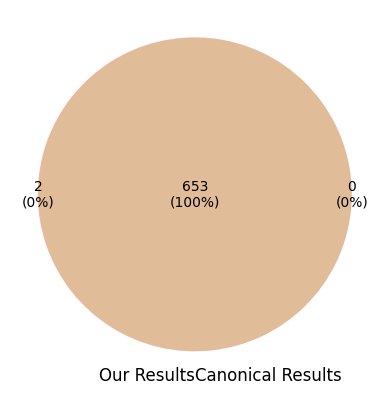

In [6]:
# comparison cell
canonical_results = parse_targetscan_result_file(canonical_result_file)

# creating comparison sets
targetscan_results_set = create_comparison_set(results_df)
canonical_results_set = create_comparison_set(canonical_results)


plot_venn_diagram(
    targetscan_results_set,
    canonical_results_set,
    s1_name="Our Results",
    s2_name="Canonical Results",
)


# TargetScan Style pretty prints

In [ ]:
def pretty_print(df):

    return df.style.set_properties(**{'text-align': 'left', 'white-space': 'pre-wrap'}).set_table_styles([dict(selector="", props=[("font-size", "12pt"), ("font-family", 'Courier')])])


def print_results(df, sequence):
    # pythonic
    names = df["name"].tolist()
    match_types = df["match_type"].tolist()
    starts = df["start"].tolist()
    ends = df["end"].tolist()
    coordinates = df["coordinates"].tolist()
    mirna_sequences = df["mirna_sequence"].tolist()

    result_strings = []
    
    # creates DNA and miRNA string
    for i in range(len(names)):

        # pythonic
        mirna_sequence = mirna_sequences[i]
        dna_start = (starts[i] - 24) if starts[i] > 25 else 0
        dna_end = ends[i]
        sequence_slice = sequence[dna_start:dna_end]
        whitespace_length = len(sequence_slice) - len(mirna_sequence)

        # creating sequence strings
        dna_string = f"5' {uracil_to_thymine(sequence_slice)} 3' position: {dna_start+1}-{dna_end} of DNA"
        mirna_string = "3' " + whitespace_length * \
            (" ") + complement(mirna_sequences[i]) + " 5' " + names[i]

        # creating middle string
        middle_string = ""
        c = -1
        for nucleotide in reversed(mirna_sequence):
            try:
                middle_string += "|" if nucleotide == sequence_slice[c] else " "
                c -= 1
            except IndexError:
                break

        # +3 in whitespace_length corresponds to the "5' " part of the sequence strings
        middle_string = (whitespace_length+3)*(" ") + middle_string[::-1]
        final_string = f"{dna_string}\n{middle_string}\n{mirna_string}"
        result_strings.append(final_string)
        
        # df that contains final results
        df = pd.DataFrame(list(zip(result_strings, match_types)), columns=["results", "match_types"])
        
        # styling final df
                
    return pretty_print(df)


print_results(results_df, sequence)


In [11]:

# mirbase stuff
mirbase_df = create_mirbase_db()
#mirbase_results = find_matches(sequence, mirbase_df)
#mirbase_results = mirbase_results[mirbase_results.match_type != "6mer"]
# compare_mirna_dataframes(mirbase_df, targetscan_df)

In [13]:
mirbase_df.shape

(2656, 2)

In [14]:
targetscan_df.shape

(2606, 4)